**1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.**

In [268]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [269]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [270]:
#тест/обучение 25/75

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [271]:
#функция предсказания

def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
#     predictions = np.zeros(X.shape[0])
#     for i, x in enumerate(X):
#         prediction = 0
#         for alg in trees_list:
#             prediction += eta * alg.predict([x])[0]
#         predictions[i] = prediction
        
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

In [12]:
#среднеквадратичная ошибка
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [222]:
#квавдратичная функция потерь
def residual(y, z):
    return - (z - y)

In [237]:
n_trees = [4, 8, 16, 32]
max_depth = [3, 7, 14, 21, 50]

**Изменения в функции обучения**

1. Ввел дополнительные словари, куда записываю данные расчетов ошибок в зависимости от максимальной глубины деревьев.
2. На одном графике рисуются train_test данные ошибок в зависимости от глубины деревьев
Такие графики рисуются для различного количества деревье.

Количество деревьев и максимальная глубина задается в списке.


In [218]:
def gb_fit(n_trees, X_train, X_test, y_train, y_test, eta, max_depth):
    
    for n_tr in n_trees:
        pic_trees = {}
        pic_train_errors = {}
        pic_test_errors = {}
        
        for md in max_depth:
              
            trees = []
            train_errors = []
            test_errors = []

            for i in range(n_tr):
                tree = DecisionTreeRegressor(max_depth=md, random_state=42)

                # первый алгоритм просто обучаем на выборке и добавляем в список
                if len(trees) == 0:
                    # обучаем первое дерево на обучающей выборке
                    tree.fit(X_train, y_train)

                    train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
                    test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
                else:
                    # Получим ответы на текущей композиции
                    target = gb_predict(X_train, trees, eta)

                    # алгоритмы начиная со второго обучаем на сдвиг
                    tree.fit(X_train, residual(y_train, target))

                    train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
                    test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

                trees.append(tree)
                
                pic_trees.update({md: trees})
                pic_train_errors.update({md: train_errors})
                pic_test_errors.update({md: test_errors})
        df_train = pd.DataFrame(pic_train_errors)
        df_test = pd.DataFrame(pic_test_errors)
        print(f'{df_train}, {df_test}, train_trees_{n_tr}')
        df_train.plot(y=max_depth, title = f'train_trees_{n_tr}')
        df_test.plot(y=max_depth, title = f'test_trees_{n_tr}')

             3             7             14            21            50
0  29131.851964  29131.851964  29131.851964  29131.851964  29131.851964
1   2855.911576    848.546638      2.577291      0.000000      0.000000
2   2382.973217    359.826881      0.000000      0.000000      0.000000
3   2146.169688    159.177469      0.000000      0.000000      0.000000,              3             7             14            21            50
0  28903.405405  28903.405405  28903.405405  28903.405405  28903.405405
1   3905.875606   4953.805602   5075.270646   5226.450450   5226.450450
2   4315.216507   5594.208927   5082.792292   5226.450450   5226.450450
3   4350.885463   5773.550834   5082.792292   5226.450450   5226.450450, train_trees_4
             3             7             14            21            50
0  29131.851964  29131.851964  29131.851964  29131.851964  29131.851964
1   2855.911576    848.546638      2.577291      0.000000      0.000000
2   2382.973217    359.826881      0.000000     

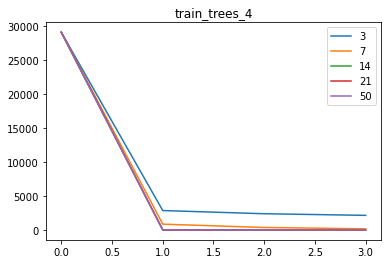

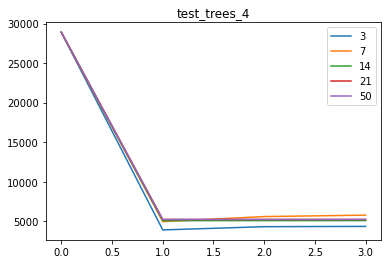

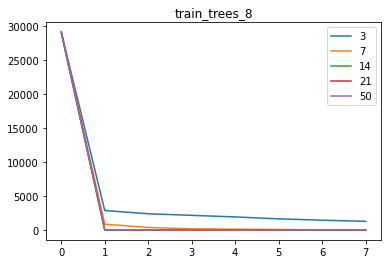

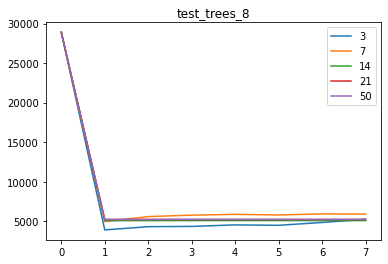

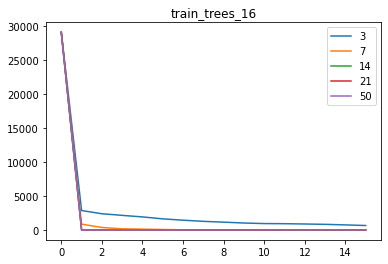

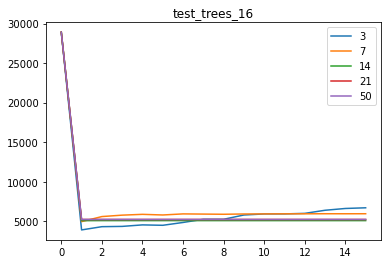

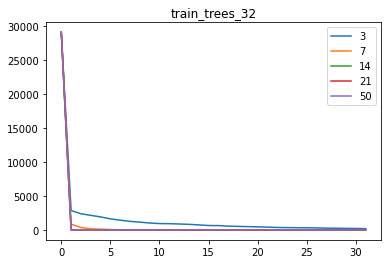

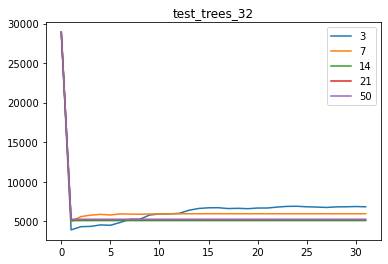

In [221]:
gb_fit(n_trees, X_train, X_test, y_train, y_test, eta, max_depth)

**Результаты**

Оптимальнее всего выбирать глубину около 20 при количестве деревьев 10.


**2.*Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.**

**ИЗМЕНЕНИЯ**

На сколько я понял, надо было трансформировать матрицу X(train test)

В каждой строчке выбирал рандомные 50% данных и снова загружал их в матрицу X_new, которую и обрабатывал.


In [288]:
def gb_stoch_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [293]:
# Число деревьев в ансамбле
n_trees = 10

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

k = int(round(len(X_train)/2,0))
X_train_new = []
for row in X_train:
    row = np.random.choice(row, k)
    X_train_new.append(row)
    
n = int(round(len(X_test)/2,0))
X_test_new = []
for row in X_test:
    row = np.random.choice(row, k)
    X_test_new.append(row)    

y_train_new = np.random.choice(y_train, int(round(len(y_train)/2)))
y_test_new = np.random.choice(y_test, int(round(len(y_test)/2)))
    
trees, train_errors, test_errors = gb_stoch_fit(n_trees, max_depth, X_train_new, X_test_new, y_train, y_test, eta)

In [294]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [296]:
evaluate_alg( X_train_new, X_test_new, y_train, y_test, trees, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 538.4728644658638
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 9691.516952751215


In [297]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

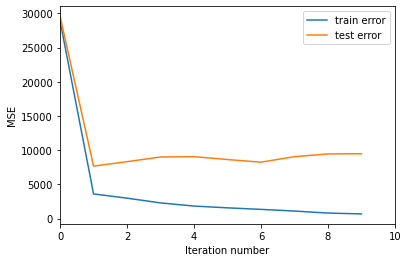

In [298]:
get_error_plot(n_trees, train_errors, test_errors)